# Extraindo Dados Utilizando SQL
A partir de um bando de dados relacional disponível no Kaggle (https://www.kaggle.com/datasets/dillonmyrick/bike-store-sample-database), trouxe alguns exemplos utilizando SQL, utilizando algumas cláusulas como *JOIN, WITH, CASE, etc*.

# Modelo Lógico
Segue abaixo o diagrama do modelo lógico, disponível no mesmo link do banco de dados.

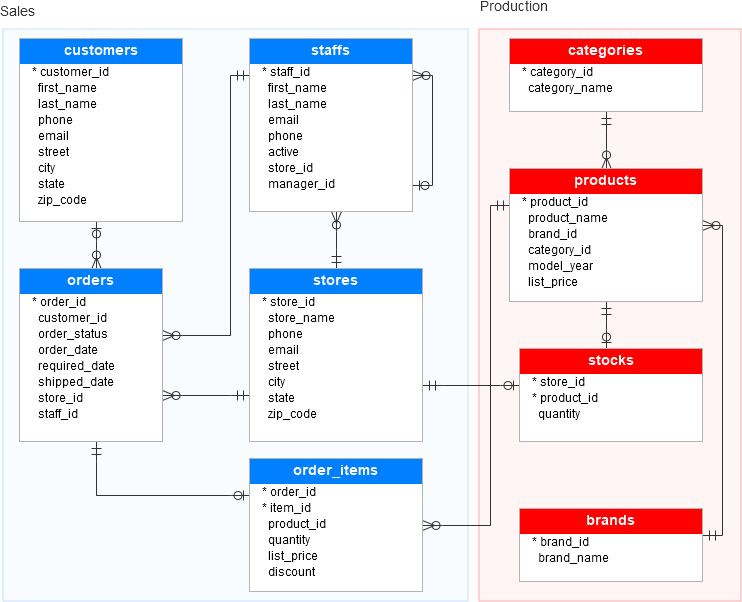




In [20]:
# Importando
import pandas as pd
import sqlite3



In [10]:
# Utilizando o pandas para ler os arquivos CSV
brands = pd.read_csv('/content/brands.csv')
categories = pd.read_csv('/content/categories.csv')
customers = pd.read_csv('/content/customers.csv')
order_items = pd.read_csv('/content/order_items.csv')
orders = pd.read_csv('/content/orders.csv')
products = pd.read_csv('/content/products.csv')
staffs = pd.read_csv('/content/staffs.csv')
stocks = pd.read_csv('/content/stocks.csv')
stores = pd.read_csv('/content/stores.csv')

# Conectando o banco de dados
connection = sqlite3.connect('bike_store.db')

# Colocando no banco de dados
brands.to_sql('brands', connection, if_exists='replace', index=False)
categories.to_sql('categories', connection, if_exists='replace', index=False)
customers.to_sql('customers', connection, if_exists='replace', index=False)
order_items.to_sql('order_items', connection, if_exists='replace', index=False)
orders.to_sql('orders', connection, if_exists='replace', index=False)
products.to_sql('products', connection, if_exists='replace', index=False)
staffs.to_sql('staffs', connection, if_exists='replace', index=False)
stocks.to_sql('stocks', connection, if_exists='replace', index=False)
stores.to_sql('stores', connection, if_exists='replace', index=False)


3

Extraindo a informação da quantidade de vendas de bicicleta por marca.
Com o diagrama do modelo lógico fica fácil a visualização dos JOIN utilizados


In [31]:


query = """
SELECT
  SUM(oi.quantity) AS "QTD Vendida",
  b.brand_name AS Marca

FROM order_items AS oi
JOIN products AS p
ON oi.product_id = p.product_id

JOIN brands AS b
ON p.brand_id = b.brand_id

GROUP BY b.brand_name
ORDER BY SUM(oi.quantity) DESC;
"""

df = pd.read_sql_query(query, connection)
df

,QTD Vendida,Marca
0,2612,Electra
1,1839,Trek
2,908,Surly
3,731,Sun Bicycles
4,376,Pure Cycles
5,331,Haro
6,138,Heller
7,118,Ritchey
8,25,Strider


Novamente, utilizando alguns JOIN, podemos responder a pergunta:
"Qual foi a média de preço das bicicletas vendidas na categoria Mountain Bike?"


In [12]:
query = """
SELECT
  ROUND(AVG((oi.list_price * (1 - oi.discount))/oi.quantity), 2) AS AVG_Mountain_Bike

FROM order_items AS oi
JOIN products AS p
ON oi.product_id = p.product_id

JOIN categories AS c
ON c.category_id = p.category_id

WHERE c.category_name = "Mountain Bikes"
"""

df = pd.read_sql_query(query, connection)
df

,AVG_Mountain_Bike
0,1170.96


Para responder a pergunta "Qual loja mais vendeu Children Bicycles",
é necessário fazer vários JOIN. Para facilitar a visualização, utilizamos o
recurso de CTE, com a cláusula WITH, criando assim tabelas temporárias, que
utilizaremos depois na query desejada.

In [30]:
query = """
WITH nome_loja_pedido AS (
SELECT
  o.order_id,
  s.store_name

FROM orders AS o
JOIN stores AS s
ON o.store_id = s.store_id
),

categoria_obj AS (
SELECT
  p.product_id,
  c.category_name

FROM products AS p
JOIN categories AS c
ON p.category_id = c.category_id
)

SELECT
  SUM(oi.quantity) AS Quantidade,
  nl.store_name AS "Nome da Loja"

FROM order_items AS oi

JOIN nome_loja_pedido AS nl
ON nl.order_id = oi.order_id

JOIN categoria_obj AS co
ON co.product_id = oi.product_id

WHERE category_name = "Children Bicycles"

GROUP BY nl.store_name
ORDER BY SUM(oi.quantity) DESC
"""

df = pd.read_sql_query(query, connection)
df

,Quantidade,Nome da Loja
0,811,Baldwin Bikes
1,251,Santa Cruz Bikes
2,117,Rowlett Bikes


Na próxima query, utilizamos novamente CTE para facilitar a visualização.
Foi utilizado também CASE para produzir uma coluna de status comparando as
vendas de 2016 para 2017, separado por cada Marca.
Foi utilizado o COALESCE para remover os valores NULL da query, o que dificultaria
a operação aritmética

In [29]:
query = """


WITH marca_produto AS (
SELECT
  p.product_id,
  b.brand_name

FROM products AS p
LEFT JOIN brands AS b
ON p.brand_id = b.brand_id
),

teste_tabela AS (
SELECT
  mp.brand_name AS Marca,
  COALESCE(SUM(CASE WHEN STRFTIME('%Y', o.order_date) = '2016' THEN oi.quantity END), 0) AS QTD2016,
  COALESCE(SUM(CASE WHEN STRFTIME('%Y', o.order_date) = '2017' THEN oi.quantity END), 0) AS QTD2017

FROM orders AS o

LEFT JOIN order_items AS oi
ON oi.order_id = o.order_id

JOIN marca_produto AS mp
ON oi.product_id = mp.product_id

GROUP BY mp.brand_name)



SELECT
  *,
  CASE WHEN QTD2017 - QTD2016 > 0 THEN "Aumentou"
       WHEN QTD2017 - QTD2016 < 0 THEN "Diminuiu"
       ELSE "Estagnou" END AS "Status"

FROM teste_tabela

ORDER BY QTD2016 DESC
"""

df = pd.read_sql_query(query, connection)
df

,Marca,QTD2016,QTD2017,Status
0,Electra,1296,832,Diminuiu
1,Surly,453,353,Diminuiu
2,Trek,436,871,Aumentou
3,Pure Cycles,291,74,Diminuiu
4,Ritchey,94,19,Diminuiu
5,Heller,93,35,Diminuiu
6,Haro,0,282,Aumentou
7,Strider,0,0,Estagnou
8,Sun Bicycles,0,633,Aumentou


Utilizando a cláusula OVER, realizamos uma Window Function para calcular o valor acumulado das vendas, sem a necessidade de agregar as linhas, como foi feito na primeira query

In [18]:
query = """

WITH data_preco_2017 AS (
SELECT
  ROUND(oi.list_price  * (1 - oi.discount), 2) AS list_price,
	o.order_date,
	o.store_id
FROM order_items AS oi

JOIN orders AS o
ON oi.order_id = o.order_id

WHERE o.order_status = 4 AND STRFTIME('%Y', o.order_date) = '2017'
ORDER BY 3, 2
)

SELECT
	list_price,
	order_date,
	store_id,
	ROUND(SUM(list_price) OVER(
		PARTITION BY store_id
		ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW), 2)
		AS accumulated_value

FROM data_preco_2017
"""

df = pd.read_sql_query(query, connection)
df

,list_price,order_date,store_id,accumulated_value
0,263.99,2017-01-03,1,263.99
1,391.99,2017-01-07,1,655.98
2,503.49,2017-01-07,1,1159.47
3,2799.99,2017-01-07,1,3959.46
4,712.49,2017-01-08,1,4671.95
...,...,...,...,...
2019,448.25,2017-12-25,3,232798.41
2020,494.99,2017-12-25,3,233293.40
2021,557.99,2017-12-25,3,233851.39
2022,479.99,2017-12-25,3,234331.38
